<a href="https://colab.research.google.com/github/bagfat/telu-parking/blob/main/algorithm_plat_number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ini merupakan refrensi program untuk ***License plate recognition using CNN***

https://www.kaggle.com/code/caasperart/license-plate-recognition-using-cnn/notebook

In [ ]:
# !pip install imutils -q

import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
# import imutils
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from skimage import io
import urllib.request

from datetime import datetime
import uuid


def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

In [ ]:
import kagglehub
import shutil
import os

# 1. Download dataset (masuk ke cache dulu)
cache_path = kagglehub.dataset_download("caasperart/haarcascadeplatenumber")

# 2. Tentukan folder tujuan di /content/
destination_path = '/content/dataset_plat'

# 3. Cek apakah folder tujuan sudah ada (hapus dulu jika ada biar bersih)
if os.path.exists(destination_path):
    shutil.rmtree(destination_path)

# 4. Salin file dari Cache ke /content/
print(f"Menyalin data dari {cache_path} ke {destination_path}...")
shutil.copytree(cache_path, destination_path)

print("✅ Selesai! Dataset sekarang ada di:", destination_path)

# 5. Update variabel path agar kode selanjutnya menggunakan path baru
path = destination_path

100%|██████████| 1.04G/1.04G [00:13<00:00, 85.1MB/s]

Extracting files...


Menyalin data dari /root/.cache/kagglehub/datasets/caasperart/haarcascadeplatenumber/versions/10 ke /content/dataset_plat...
✅ Selesai! Dataset sekarang ada di: /content/dataset_plat


In [ ]:
indeximg=0
filepath=[]
for root, dirname, filename in os.walk('dataset_plat'):
    for file in filename:
        filepath.append(os.path.join(root, file))

In [ ]:
savepath = '/content/working'
os.makedirs(savepath, exist_ok=True)
print(f"Folder '{savepath}' berhasil dibuat (atau sudah ada).")

Folder '/content/working' berhasil dibuat (atau sudah ada).


In [ ]:
for ra in range(0, len(filename)):
    img = cv2.imread(filepath[indeximg])

    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
    blured  = cv2.GaussianBlur(hisimg, (21,21), 0)
    edged   = cv2.Canny(blured, 10, 180)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
    dilate = cv2.dilate(edged, kernel, iterations=1)

    contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    image_copy = img.copy()
    cv2.drawContours(image_copy, contours, -1, (0, 0, 255), 2)

    platno=[]
    index=0

    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        aspect_ratio = w/h

        if w > 560 and h>350 and h<1100 and aspect_ratio > 1.6 and aspect_ratio<=2.6:
            print(f'aspect ratio from index: {index}, {aspect_ratio}, w: {w}, h: {h}')
            platno.append(index)
        index += 1
    print(f'detected plat no: {len(platno)}, index: {indeximg}')


    if len(platno)>0:
        try:

            for plat in platno:
                detectedimg = img.copy()
                x,y,w,h = cv2.boundingRect(contours[plat])
                croppedimg = img[y: y+h, x:x+w]

            ##########################################################################

                grayimg = cv2.cvtColor(croppedimg, cv2.COLOR_BGR2GRAY)
                hisimg  = cv2.adaptiveThreshold(grayimg, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 125, 1)
                blured  = cv2.GaussianBlur(hisimg, (29,29), 0)
                edged   = cv2.Canny(blured, 10, 120)

                kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
                dilate = cv2.dilate(edged, kernel, iterations=1)

                contours, _ = cv2.findContours(dilate, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)
                image_copy = croppedimg.copy()
                imgrec = croppedimg.copy()

                platno=[]
                index=0
                realPlatno=0

                for contour in contours:
                    x,y,w,h = cv2.boundingRect(contour)
                    aspect_ratio = w/h
                    luas = w*h

                    if w > 100 and h>=150 and h <410 and aspect_ratio <= 0.7 :
                        platno.append(index)
                        cv2.drawContours(image_copy, contours, index, (0, 255, 0), 2)
                        print(f'x: {x}, y: {y}, w: {w}, h: {h}')
                        realPlatno+=1
                    index += 1
                print(f'detected candidate plat no: {len(platno)}')

                urutx = []
                for char in platno:
                    x,y,w,h = cv2.boundingRect(contours[char])
                    urutx.append(x)
                urutx = sorted(urutx)

                ## urutkan karakter plat nomor dari kiri ke kanan
                cropCharUrut=[]
                for ux in urutx:
                    for char in platno :
                        x,y,w,h = cv2.boundingRect(contours[char])
                        if x == ux:
                            cropCharUrut.append(char)
                            break
                o = 0
                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    o=0
                    for i in cropCharUrut:
                        if c==i:
                            continue
                        x2,y2,w2,h2 = cv2.boundingRect(contours[i])

                        if abs(x-x2) < 10:
                            cropCharUrut.pop(o)
                        o+=1
                print(cropCharUrut)

                for c in cropCharUrut:
                    x,y,w,h = cv2.boundingRect(contours[c])
                    cv2.rectangle(imgrec, (x,y), (x+w,y+h), (0,0,255),2)

#                 display(imgrec, "box plat no")

                ##########################################################################

                # tampilkan karakter yang telah terpotong
                imgs=[]
                savepath='/content/working/'
                imgHeight = 40
                imgWidth  = 40

                for char in cropCharUrut:
                    filename = str(datetime.now().strftime("%d_%m_%Y-%H_%M_%S")) + str(uuid.uuid4()) + ".jpg"
                    filename = os.path.join(savepath, filename)
                    print(filename)

                    x,y,w,h = cv2.boundingRect(contours[char])
                    crop = grayimg[y: y+h, x:x+w]
                    ret,thresh = cv2.threshold(crop,127,255,cv2.THRESH_BINARY)
                    char_crop = cv2.resize(thresh, (imgWidth, imgHeight))
                    imgs.append(char_crop)
                    cv2.imwrite(filename, char_crop)
#                     display(char_crop)

        except:
            pass

    # increment indeximg
    indeximg +=1

Output streaming akan dipotong hingga 5000 baris terakhir.
x: 791, y: 50, w: 122, h: 250
x: 793, y: 52, w: 117, h: 246
x: 950, y: 44, w: 123, h: 253
x: 952, y: 46, w: 118, h: 249
x: 1198, y: 37, w: 124, h: 251
x: 1200, y: 39, w: 118, h: 247
x: 1354, y: 31, w: 128, h: 257
x: 1356, y: 33, w: 122, h: 253
detected candidate plat no: 15
[111, 116, 122, 123, 129, 131, 139, 145]
/content/working/03_01_2026-12_25_23291148e7-814f-4103-8f0b-af7e8bcca59d.jpg
/content/working/03_01_2026-12_25_23b8ba492f-5b88-4b0d-bfb6-821c54a09eb3.jpg
/content/working/03_01_2026-12_25_23348d5ce1-a11c-4bda-9666-002bbed47f90.jpg
/content/working/03_01_2026-12_25_235bff3852-6805-437e-9d26-528bc3c18fb4.jpg
/content/working/03_01_2026-12_25_2308df7416-e249-4027-9671-a644a6edd834.jpg
/content/working/03_01_2026-12_25_23f4d22fb4-32a9-4bd1-8689-599f24c81e12.jpg
/content/working/03_01_2026-12_25_23d75c88e3-dbe2-46e7-a6bd-65800cb5a942.jpg
/content/working/03_01_2026-12_25_23021fd99f-c6d6-4751-bdb9-d025e6c115cc.jpg
aspect ra

In [ ]:
"""
referensi:
https://www.tensorflow.org/tutorials/images/classification
"""

import tensorflow as tf # Pastikan baris ini ada
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#path = '/root/.cache/kagglehub/datasets/caasperart/haarcascadeplatenumber/versions/10/DatasetCharacter/DatasetCharacter'
path = '/content/dataset_plat/DatasetCharacter/DatasetCharacter'

batchSize = 32
imgHeight = 40
imgWidth  = 40

trainDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split = 0.2,
    subset="training",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size = batchSize )

valDs = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(imgHeight, imgWidth),
    batch_size=batchSize )

className = trainDs.class_names
AUTOTUNE = tf.data.AUTOTUNE

train_ds = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = valDs.cache().prefetch(buffer_size=AUTOTUNE)

# buat model dengan tensorflow sequential
numClass = len(className)

# PERBAIKAN DI SINI
model = Sequential([
    # Hapus '.preprocessing', langsung panggil layers.Rescaling
    layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),

    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(numClass)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Found 37234 files belonging to 36 classes.
Using 29788 files for training.
Found 37234 files belonging to 36 classes.
Using 7446 files for validation.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 40, 40, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 40, 40, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 20, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 20, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         4,644 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,156 (910.77 KB)

 Trainable params: 233,156 (910.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs=10
history = model.fit(trainDs,
                    validation_data = valDs,
                    epochs=epochs)

Epoch 1/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.7124 - loss: 1.1033 - val_accuracy: 0.9304 - val_loss: 0.2568
Epoch 2/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9442 - loss: 0.2002 - val_accuracy: 0.9470 - val_loss: 0.1932
Epoch 3/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9637 - loss: 0.1288 - val_accuracy: 0.9574 - val_loss: 0.1551
Epoch 4/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9734 - loss: 0.0913 - val_accuracy: 0.9648 - val_loss: 0.1349
Epoch 5/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9804 - loss: 0.0668 - val_accuracy: 0.9643 - val_loss: 0.1380
Epoch 6/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9846 - loss: 0.0540 - val_accuracy: 0.9629 - val_loss: 0.1539
Epoch 7/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9859 - loss: 0.0460 - val_accuracy: 0.9679 - val_loss: 0.1367
Epoch 8/10
931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9895 - loss: 0.0380 - val_accuracy:

In [ ]:
model.save("/content/working/model.h5")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('my_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Tambahkan optimasi kuantisasi agar sangat ringan
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model_plate.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpuss_uv7z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 40, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 36), dtype=tf.float32, name=None)
Captures:
  135118963194768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954728912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954727184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954727760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954728144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954728720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118954726992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118951033616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118951036688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135118951038032: TensorSpec(shape=(), dtype=tf.resource, name=None)


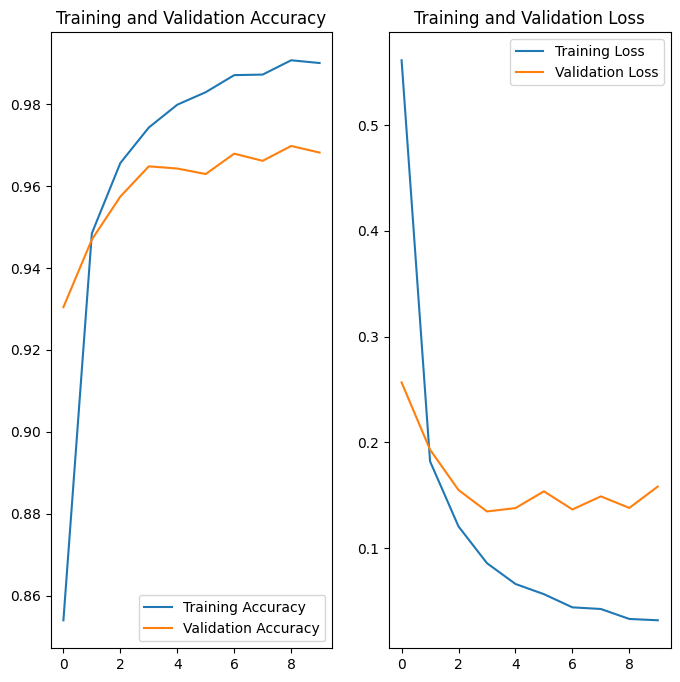

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.save('my_model.h5') # Save trained model

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



--- HASIL PEMBACAAN PER HURUF ---

🚗 PLAT NOMOR TERDETEKSI: AD2914JG


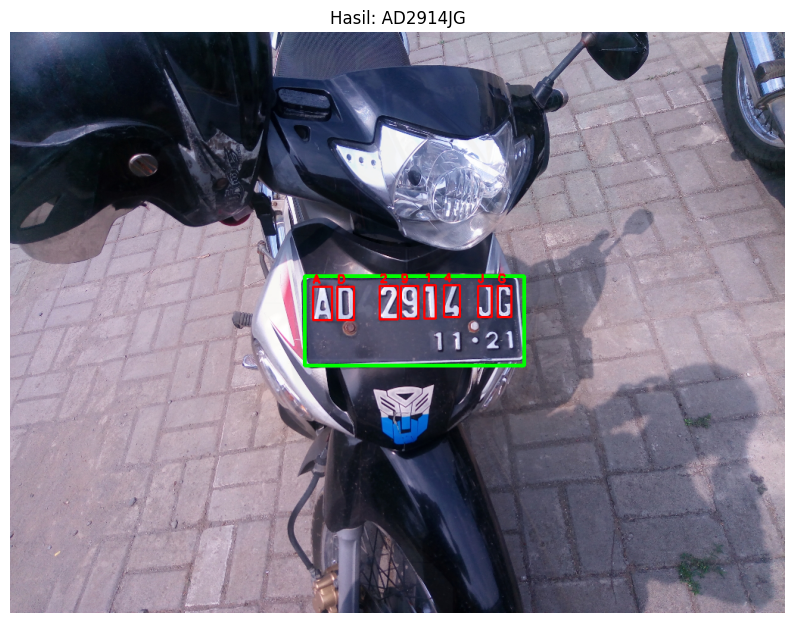

In [11]:
# --- mainProgram.py (Versi Colab Fixed) ---
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os

# --- KONFIGURASI ---
image_path = '/content/AD2914JG.jpg'  # <--- GANTI DENGAN PATH GAMBAR ANDA
model_path = '/content/model_plate.tflite'      # Sesuai hasil training di atas

# Cek File dulu
if not os.path.exists(image_path):
    print("❌ Gambar tidak ditemukan! Upload dulu gambar mobil.")
elif not os.path.exists(model_path):
    print("❌ Model tidak ditemukan! Jalankan Training.py dulu.")
else:
    # 1. LOAD IMAGE & PRE-PROCESSING
    img = cv.imread(image_path)
    # Resize agar proses lebih cepat & standar (sesuai repo)
    img = cv.resize(img, (int(img.shape[1]*.4), int(img.shape[0]*.4)))

    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Normalisasi Cahaya (Opening & Otsu Threshold)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20))
    img_opening = cv.morphologyEx(img_gray, cv.MORPH_OPEN, kernel)
    img_norm = img_gray - img_opening
    (thresh, img_norm_bw) = cv.threshold(img_norm, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # 2. DETEKSI PLAT (PAKAI CONTOURS)
    contours_vehicle, hierarchy = cv.findContours(img_norm_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    index_plate_candidate = []
    index_counter_contour_vehicle = 0

    # Filter kotak yang mirip plat nomor (berdasarkan rasio lebar:tinggi)
    for contour_vehicle in contours_vehicle:
        x,y,w,h = cv.boundingRect(contour_vehicle)
        aspect_ratio = w/h

        # Syarat: Lebar >= 200px dan Rasio <= 4
        if w >= 200 and aspect_ratio <= 4:
            index_plate_candidate.append(index_counter_contour_vehicle)
        index_counter_contour_vehicle += 1

    # Logika memilih kandidat plat
    img_show_plate = img.copy()
    plate_found = False

    if len(index_plate_candidate) == 0:
        print("⚠️ Plat nomor tidak terdeteksi oleh Contours.")
    else:
        # Jika ada 2 kandidat, ambil yang kedua (biasanya yang benar menurut repo)
        idx_pilih = index_plate_candidate[1] if len(index_plate_candidate) > 1 else index_plate_candidate[0]

        x_plate, y_plate, w_plate, h_plate = cv.boundingRect(contours_vehicle[idx_pilih])
        img_plate_gray = img_gray[y_plate:y_plate+h_plate, x_plate:x_plate+w_plate]
        plate_found = True

        # Visualisasi Kotak Plat
        cv.rectangle(img_show_plate, (x_plate, y_plate), (x_plate+w_plate, y_plate+h_plate), (0,255,0), 3)

    # 3. SEGMENTASI & BACA KARAKTER (Jika plat ketemu)
    if plate_found:
        # Preprocessing Plat (Thresholding lagi)
        (thresh, img_plate_bw) = cv.threshold(img_plate_gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
        kernel_cross = cv.getStructuringElement(cv.MORPH_CROSS, (3,3))
        img_plate_bw = cv.morphologyEx(img_plate_bw, cv.MORPH_OPEN, kernel_cross)

        # Cari Kontur Huruf
        contours_plate, hierarchy = cv.findContours(img_plate_bw, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

        index_chars_candidate = []
        index_counter = 0

        # Filter Huruf
        for contour_plate in contours_plate:
            x_char, y_char, w_char, h_char = cv.boundingRect(contour_plate)
            # Syarat tinggi 40-60 piksel (Sesuai repo)
            if h_char >= 40 and h_char <= 60 and w_char >= 10:
                index_chars_candidate.append(index_counter)
            index_counter += 1

        if not index_chars_candidate:
            print("⚠️ Karakter tidak tersegmentasi.")
        else:
            # Load Model CNN
            #model = keras.models.load_model(model_path)
            interpreter = tf.lite.Interpreter(model_path=model_path)
            interpreter.allocate_tensors()

            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()

            # Daftar Kelas (Harus sama dengan Training.py)
            # Repo ini pakai manual list, pastikan urutannya sama dengan folder dataset Anda!
            # Ini contoh standar, sesuaikan jika dataset Anda beda urutan
            class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
                           'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
                           'U', 'V', 'W', 'X', 'Y', 'Z']

            # Sorting Karakter dari Kiri ke Kanan
            x_coors = []
            for i in index_chars_candidate:
                x, y, w, h = cv.boundingRect(contours_plate[i])
                x_coors.append(x)

            # Urutkan index berdasarkan posisi x
            sorted_indices = [x for _, x in sorted(zip(x_coors, index_chars_candidate))]

            full_plate_number = ""

            print("\n--- HASIL PEMBACAAN PER HURUF ---")
            for char_idx in sorted_indices:
                x, y, w, h = cv.boundingRect(contours_plate[char_idx])

                # Crop & Resize ke 40x40
                char_crop = img_plate_bw[y:y+h, x:x+w]
                char_crop = cv.cvtColor(char_crop, cv.COLOR_GRAY2BGR)
                char_crop = cv.resize(char_crop, (40, 40))

                # Predict
                img_array = keras.preprocessing.image.img_to_array(char_crop)
                img_array = tf.expand_dims(img_array, 0)

                predictions = model.predict(img_array, verbose=0)
                score = tf.nn.softmax(predictions[0])
                pred_class = class_names[np.argmax(score)]

                full_plate_number += pred_class

                # Gambar kotak di setiap huruf
                cv.rectangle(img_show_plate, (x_plate+x, y_plate+y), (x_plate+x+w, y_plate+y+h), (0,0,255), 2)
                cv.putText(img_show_plate, pred_class, (x_plate+x, y_plate+y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2)

            print(f"\n🚗 PLAT NOMOR TERDETEKSI: {full_plate_number}")

            # Tampilkan Hasil Akhir
            plt.figure(figsize=(10,10))
            plt.imshow(cv.cvtColor(img_show_plate, cv.COLOR_BGR2RGB))
            plt.title(f"Hasil: {full_plate_number}")
            plt.axis('off')
            plt.show()